<a href="https://colab.research.google.com/github/tommy11jo/classifier_experiments/blob/main/classifier_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

transform = transforms.Compose([transforms.ToTensor()])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train = datasets.STL10('./data', download=True, split='train', transform=transform)
train_loader = DataLoader(train, batch_size=64)

# Download and load the test data
test = datasets.STL10('./data', download=True, split='test', transform=transform)
test_loader = DataLoader(test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


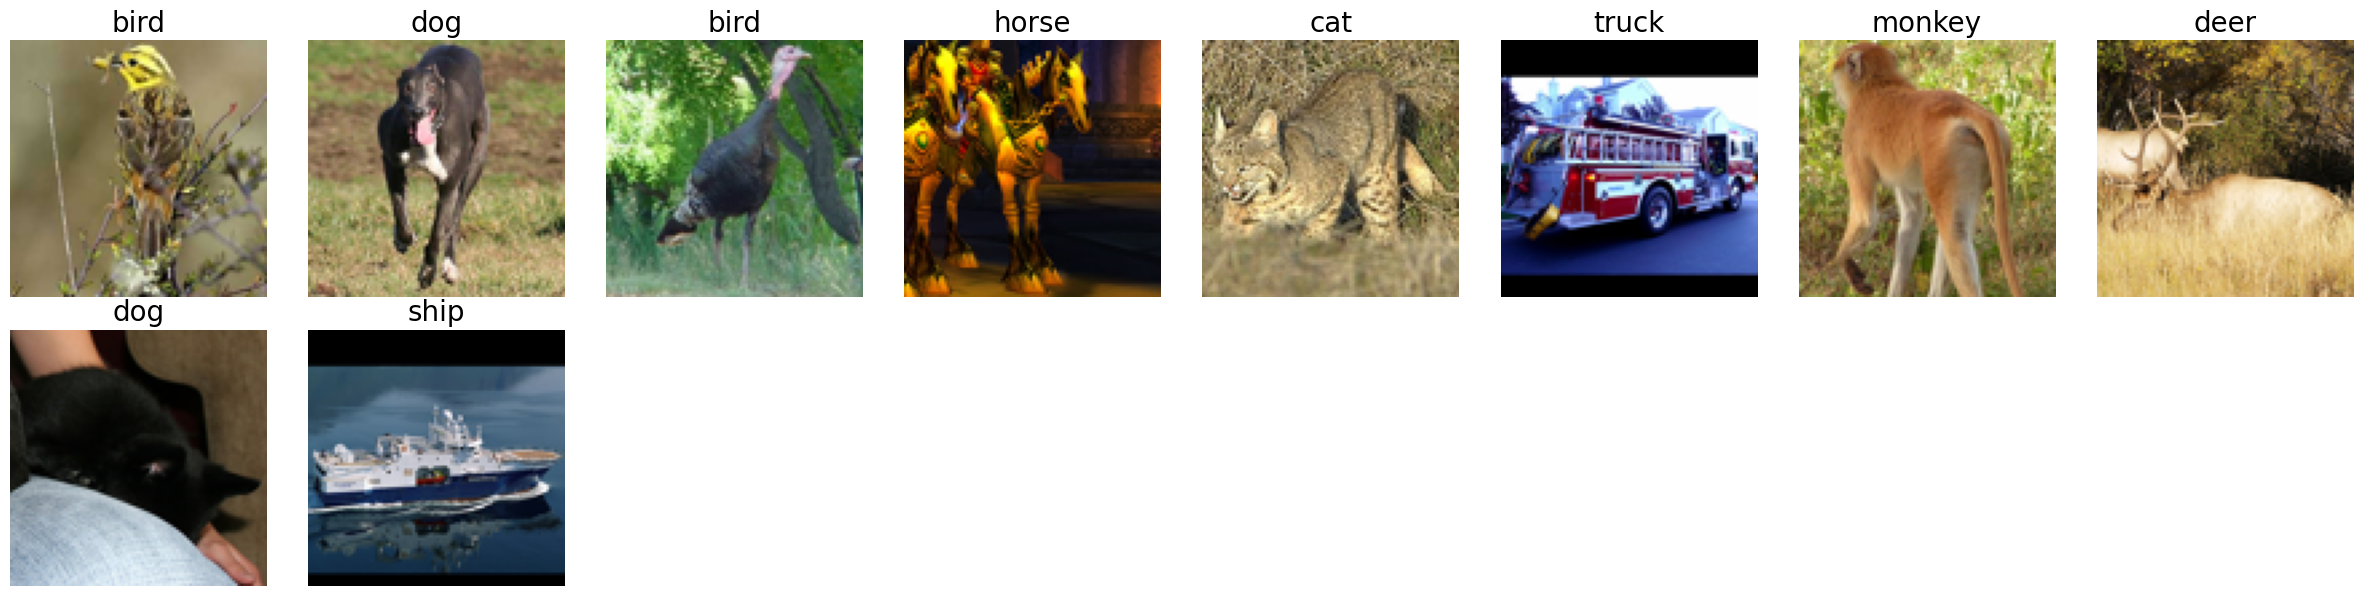

Image size: torch.Size([3, 96, 96])
1 5 1 6 3 9 7 4 5 8


In [2]:
import matplotlib.pyplot as plt
import numpy as np

class_names = train.classes
def imshow(img, label, class_names):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(class_names[label], fontsize=20)
    plt.axis('off')

def multi_imshow(imgs, labels, class_names):
    num_imgs = len(imgs)
    cols = 8
    rows = (len(imgs) // cols) + 1
    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(num_imgs):
        plt.subplot(rows, cols, i+1)
        imshow(imgs[i], labels[i].item(), class_names)
    plt.tight_layout()
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

num_view = 10
multi_imshow(images[:num_view], labels[:num_view], class_names)

print('Image size:', images[0].shape)
print(' '.join(f'{labels[j].item()}' for j in range(num_view)))

In [3]:

train.classes

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

In [4]:
# Plan: Train straight out, then try training with progressive resizing and see if it improves
# Horse car truck
nclasses = 3
cats = ['car', 'horse', 'truck']
cat_inds = [2, 6, 9]
# cat_inds = [train.classes.index(cat) for cat in cats]
cat_inds.index(6)

1

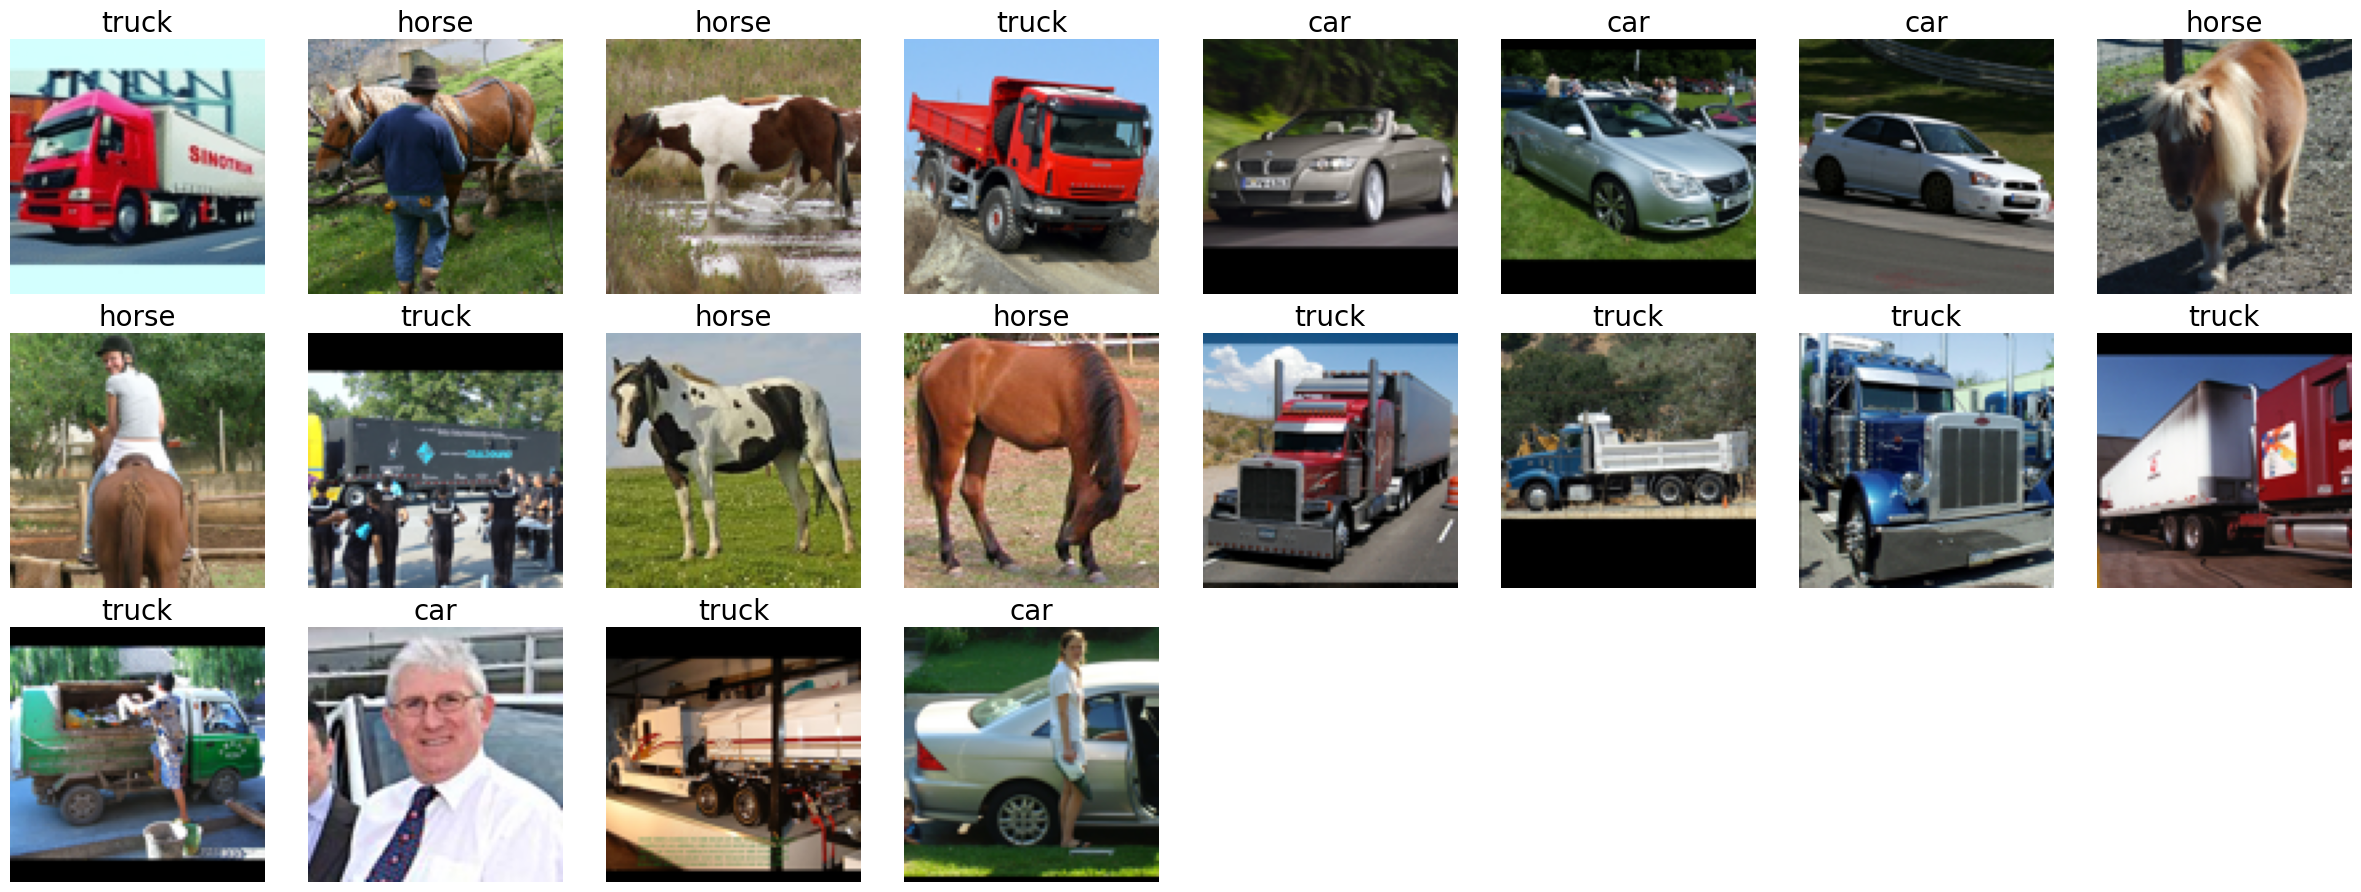

In [5]:
def prepare_data(otrain, otest):
    train = [(data, cat_inds.index(label)) for data, label in otrain if label in cat_inds]
    train_loader = DataLoader(train, batch_size=32, shuffle=True, pin_memory=False)

    test = [(data, cat_inds.index(label)) for data, label in otest if label in cat_inds]
    test_loader = DataLoader(test, batch_size=32, shuffle=True, pin_memory=False)
    return train_loader, test_loader
train_loader, test_loader = prepare_data(train, test)

num_show = 20
train_iter = iter(train_loader)
imgs, labels = next(train_iter)
multi_imshow(imgs[:num_show], labels[:num_show], cats)

In [6]:
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclasses)
model = model.to(device)



def run_train(model, loader, lr=0.001, num_epochs=4):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  trials = 0
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for inputs, labels in loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          trials += inputs.size(0)
      epoch_loss = running_loss / trials
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
run_train(model, train_loader)

Using cuda device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/4, Loss: 0.4831
Epoch 2/4, Loss: 0.0570
Epoch 3/4, Loss: 0.0168
Epoch 4/4, Loss: 0.0114


In [7]:
def accuracy(model, loader, max_trials=None):
    running_acc = 0.0
    trials = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        preds = outputs.argmax(axis=1)
        acc = (preds == labels).sum() / len(inputs)
        running_acc += acc * len(inputs)
        trials += len(inputs)
        if max_trials and trials > max_trials: break

    total_acc = running_acc / trials
    return total_acc

train_acc = accuracy(model, train_loader, max_trials=400)
test_acc = accuracy(model, test_loader, max_trials=400)
print('Train acc:', train_acc)
print('Test acc:', test_acc)

Train acc: tensor(0.9856, device='cuda:0')
Test acc: tensor(0.9471, device='cuda:0')


In [9]:
## PLAN ##
# Task: Classification of car, truck, or horse
# Test accuracy percentages
# - (94.5%) resnet18
# - (94.5%) resnet34, lr=0.005, num_epochs=4
# - (95.0%) resnet50
# - (95.4%) resnet34, normalize, lr=0.005, num_epochs=4
# - (95.8%) resnet34, normalize, 1x data augmented, lr=0.005, num_epochs=4
# Note: All of these have near 0 training set error (like 99.9%), indicating overfitting. When I try to fit less, I get worse accuracy.
# Question: I should be able to get same level of validation set accuracy with less overfitting right? Then how?

# - reset34, data aug, label smoothing
# Try building from scratch
# - resnet34, data aug, label smoothing, progressive resizing


# Uses SGD

In [10]:
train_loader, test_loader = prepare_data(train, test)

model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclasses)
model = model.to(device)

run_train(model, train_loader, lr=0.001, num_epochs=6)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 143MB/s]


Epoch 1/6, Loss: 0.4960
Epoch 2/6, Loss: 0.0497
Epoch 3/6, Loss: 0.0161
Epoch 4/6, Loss: 0.0053
Epoch 5/6, Loss: 0.0045
Epoch 6/6, Loss: 0.0020


In [11]:
train_acc = accuracy(model, train_loader)
test_acc = accuracy(model, test_loader)
print('Train acc:', train_acc)
print('Test acc:', test_acc)

Train acc: tensor(0.9980, device='cuda:0')
Test acc: tensor(0.9425, device='cuda:0')


In [12]:
train_loader, test_loader = prepare_data(train, test)

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclasses)
model = model.to(device)

run_train(model, train_loader, lr=0.001, num_epochs=4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.2MB/s]


Epoch 1/4, Loss: 0.5216
Epoch 2/4, Loss: 0.0450
Epoch 3/4, Loss: 0.0118
Epoch 4/4, Loss: 0.0055


In [13]:
train_acc = accuracy(model, train_loader)
test_acc = accuracy(model, test_loader)
print('Train acc:', train_acc)
print('Test acc:', test_acc)

Train acc: tensor(1., device='cuda:0')
Test acc: tensor(0.9488, device='cuda:0')


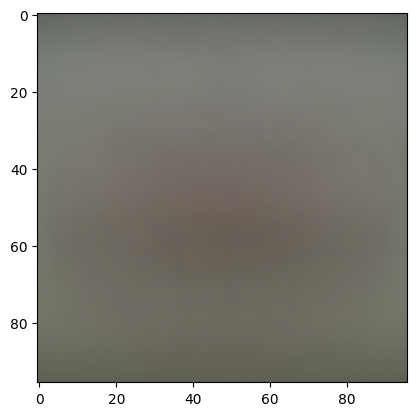

(0.44671112, 0.43981045, 0.40664744)

In [14]:
# Quick test: calculate the rgb mean and std here
# train_loader, test_loader = prepare_data(train, test)
all_imgs = [img for img, label in train]
avg_img = np.mean(np.stack(all_imgs), axis=0)
# print(avg_img[:3][:3][:3])

avg_img_rearranged = np.transpose(avg_img, (1, 2, 0))
plt.imshow(avg_img_rearranged)
plt.show()

avg_r = np.mean(avg_img[0, :, :])
avg_g = np.mean(avg_img[1, :, :])
avg_b = np.mean(avg_img[2, :, :])
avg_r, avg_g, avg_b


In [24]:
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
class CustomDataset(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image, label = self.data[idx]
    if self.transform:
      image = self.transform(image)
    return image, label

def prepare_data_normalized(otrain, otest, train_transform, test_transform):

    train_data = [(data, cat_inds.index(label)) for data, label in otrain if label in cat_inds]
    test_data = [(data, cat_inds.index(label)) for data, label in otest if label in cat_inds]

    train_dataset = CustomDataset(train_data, transform=transform)
    test_dataset = CustomDataset(test_data, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=False)

    return train_loader, test_loader
train_transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_loader, test_loader = prepare_data_normalized(train, test, transform, transform)
# train_loader, test_loader = prepare_data(train, test)


model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclasses)
model = model.to(device)

run_train(model, train_loader, lr=0.005, num_epochs=4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/4, Loss: 0.3718
Epoch 2/4, Loss: 0.0453
Epoch 3/4, Loss: 0.0206
Epoch 4/4, Loss: 0.0055


In [16]:
train_acc = accuracy(model, train_loader)
test_acc = accuracy(model, test_loader)
print('Train acc:', train_acc)
print('Test acc:', test_acc)

Train acc: tensor(0.9973, device='cuda:0')
Test acc: tensor(0.9542, device='cuda:0')


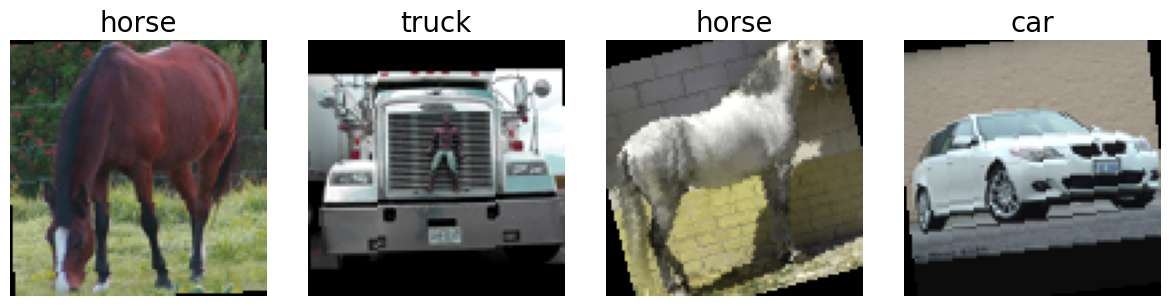

In [44]:
from torchvision.transforms import v2

def run_train(model, loader, lr=0.001, num_epochs=4):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  trials = 0
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0
      for inputs, labels in loader:
          inputs = torch.cat((inputs, augment_images(inputs, num_transforms=1))) # increase batch size
          inputs = inputs.to(device)

          labels = torch.cat((labels, labels)) # handle increased batch size
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          trials += inputs.size(0)
      epoch_loss = running_loss / trials
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


def augment_images(imgs, num_transforms=1):
  augmented = []
  for _ in range(num_transforms):
    for img in imgs:
      new_img = aug_transform(img)
      augmented.append(new_img)
  return torch.stack(augmented)

aug_transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    v2.RandomRotation(degrees=(0, 15)),
    v2.ToDtype(torch.float32, scale=True),
])
sample_train, sample_labels = next(iter(train_loader))
aug_sample = [aug_transform(x) for x in sample_train[:4]]
multi_imshow(aug_sample, sample_labels[:4], cats) # Note: fake labels
# augmented_images = augment_images(train)
# imgs = torch.cat(imgs, augmented_images)
# train_loader, test_loader = prepare_data_normalized(augmented_images, test, test_transform, test_transform)
# len(train), len(augmented_images)

In [45]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclasses)
model = model.to(device)

run_train(model, train_loader, lr=0.005, num_epochs=4)

Epoch 1/4, Loss: 0.3562
Epoch 2/4, Loss: 0.0552
Epoch 3/4, Loss: 0.0250
Epoch 4/4, Loss: 0.0078


In [46]:
train_acc = accuracy(model, train_loader)
test_acc = accuracy(model, test_loader)
print('Train acc:', train_acc)
print('Test acc:', test_acc)

Train acc: tensor(0.9980, device='cuda:0')
Test acc: tensor(0.9504, device='cuda:0')
